## 📘 SANSA
Welcome to the **official SANSA demo**. This notebook lets you interactively explore **few-shot segmentation** across image pairs.

You can guide SANSA with simple visual prompts:  
- 📦 **Box** — draw a box around the object  
- 🟢 **Point** — click on the object you want to segment  
- ✏️ **Scribble** — sketch roughly over the object area  
- 🎭 **Mask** — outline the full object region  

SANSA will automatically transfer that concept to the **target image**, segmenting the same object class.  
It works seamlessly in both **Google Colab** and **Jupyter Notebook**.

**Resources:**  [📄 Paper](https://arxiv.org/abs/2505.21795) • [🌐 Project Page](https://claudiacuttano.github.io/SANSA/)


## 1) Setup 

In [1]:
import sys, os

# Detect environment
IN_COLAB   = 'google.colab' in sys.modules
IN_JUPYTER = (not IN_COLAB) and ('ipykernel' in sys.modules)

# Clone repo and install deps (Colab)
if IN_COLAB and not os.path.exists('SANSA'):
    !git clone https://github.com/claudiacuttano/SANSA.git
    %cd SANSA

# Ensure pretrained weights
os.makedirs("pretrain", exist_ok=True)
RESUME_PATH = "pretrain/adapter_sansa_universal.pth"
if not os.path.exists(RESUME_PATH):
    try:
        import gdown 
    except Exception:
        !pip install gdown -q
    !gdown 1nPOdRfMfo3MQRSi1qkPEri7Gl6FCEVHe -O {RESUME_PATH}

## 2) Imports

In [3]:
import os, re, numpy as np, torch, matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from pathlib import Path
from os.path import join, basename
from util.demo_sansa import (
    img_size, show_ref_tgt, demo_points, demo_box, demo_scribble, demo_mask, generate_scribble, DemoCtx, predict_with_ctx
)
def set_prompt_mode(prompt_mode: str):
    assert prompt_mode in ['interactive', 'manual'], f"you should set PROMPT_INPUT_MODE to either 'interactive' or 'manual', instead it is {prompt_mode}"
    try:
        plt.close('all')
        # extra belt-and-suspenders: close any fig managers
        for manager in list(mpl._pylab_helpers.Gcf.get_all_fig_managers()):
            try:
                manager.canvas.close_event()
            except Exception:
                pass
    except Exception:
        pass

    # Plotting backend
    if IN_JUPYTER and prompt_mode == 'interactive':
        get_ipython().run_line_magic('matplotlib', 'widget')
    else:
        get_ipython().run_line_magic('matplotlib', 'inline')

## 🧠 3) Build the model

Instantiate **SANSA** and load the pretrained checkpoint.

In [4]:
from models.sansa import build_sansa
from util.commons import resume_from_checkpoint

device = torch.device("cuda")
model  = build_sansa(channel_factor=0.8).to(device)

assert os.path.exists(RESUME_PATH), f"Checkpoint not found at {RESUME_PATH}"
resume_from_checkpoint(RESUME_PATH, model)
model.eval()

print(f"✓ SANSA loaded!")

✓ SANSA loaded!


## 🖼️ 4) Select sample images

For convenience, we **provide sample images** under `assets/demo/images/`.  
Some examples also include optional class masks under `assets/demo/masks/`.

Set the two indices below to choose the **reference** and **target** images. A preview of the selected pair is displayed automatically.

Reference: image011.jpg  |  Target: image005.jpg


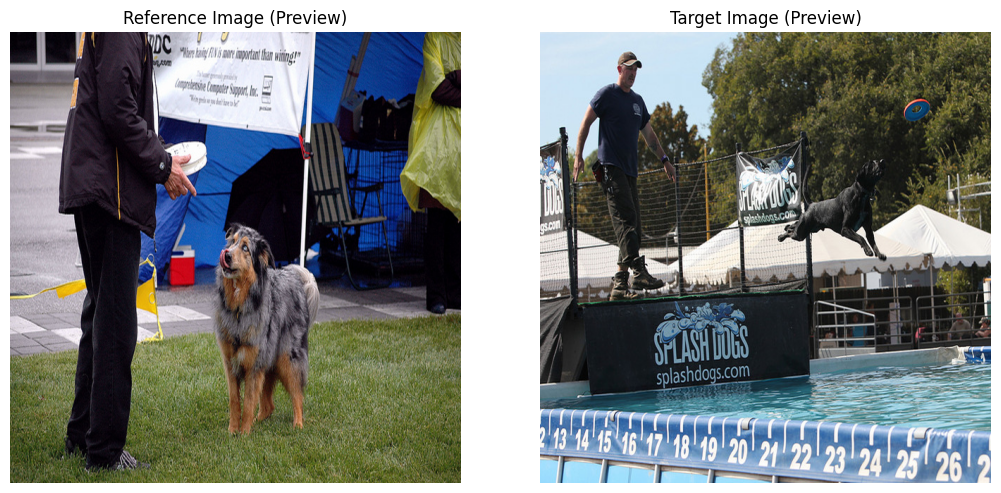

In [5]:
demo_root = 'assets/demo/images_demo'
mask_root = 'assets/demo/masks_demo'

folder = Path(demo_root)
paths = sorted(list(folder.glob("*.jpg")) + list(folder.glob("*.png")), key=lambda p: int(re.search(r'\d+', p.stem).group()))

ref_id, tgt_id = 10, 4   # ✏️ edit indices between 0-12

# images
reference_img = Image.open(paths[ref_id]).convert("RGB").resize((img_size, img_size))
target_img    = Image.open(paths[tgt_id]).convert("RGB").resize((img_size, img_size))

# masks
ref_stem = Path(paths[ref_id]).stem
tgt_stem = Path(paths[tgt_id]).stem
masks = [sorted(glob(join(mask_root, f"{ref_stem}_*.png"))), sorted(glob(join(mask_root, f"{tgt_stem}_*.png")))]

print(f"Reference: {basename(paths[ref_id])}  |  Target: {basename(paths[tgt_id])}")
show_ref_tgt(reference_img, target_img)

## 🎯 5) Choose interaction mode

All prompt types support **interactive** (draw/click) and **manual** (coordinates/paths/masks) usage.

In [83]:
PROMPT_INPUT_MODE = "interactive"   # ✏️ or: "manual"

# Run with different prompts
---


## 6) 📦 Box prompt
- **Interactive:** click & drag a rectangle on the reference image.  
- **Manual:** provide `[x0, y0, x1, y1]` in pixel coordinates (0..639).


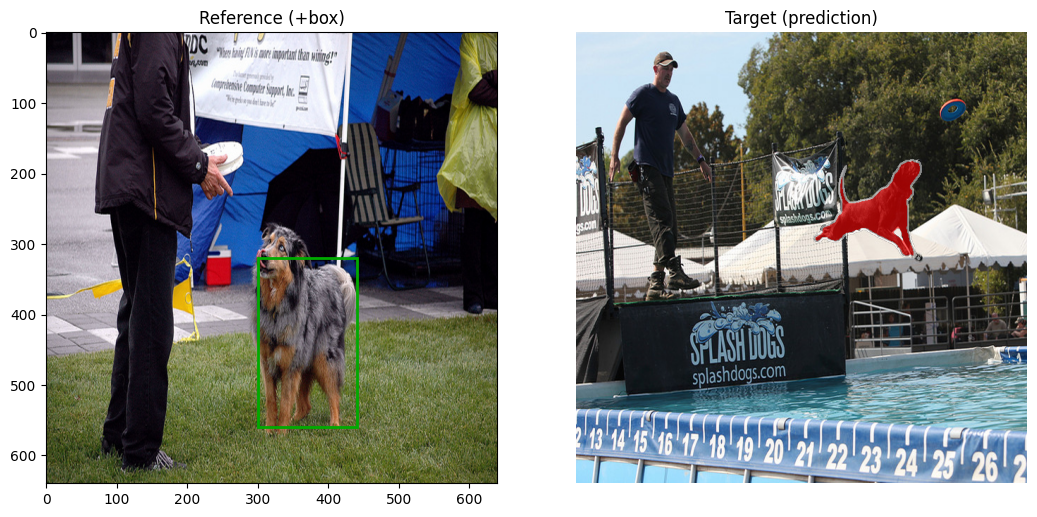

In [7]:
PROMPT_INPUT_MODE = "interactive"   # ✏️ 'interactive' or 'manual'
set_prompt_mode(PROMPT_INPUT_MODE)
ctx_box = DemoCtx(model, reference_img, target_img, device, prompt_type='box')

if PROMPT_INPUT_MODE == 'interactive':
    input_box = []
    demo_box(ctx_box, store=input_box, in_jupyter=IN_JUPYTER)
else:
    # provide box [x0, y0, x1, y1]
    BOX = np.array([300, 560, 440, 320], dtype=np.float32)  # ✏️ manual box
    pred_mask = predict_with_ctx(ctx_box, BOX)
    show_ref_tgt(reference_img, target_img, BOX, pred_mask, 'box', is_manual=True)

## 🟢 7) Point prompt

- **Interactive:** click one or more points on the object in the reference image.  
- **Manual:** provide an array of points `[[x, y], ...]` (0..639).

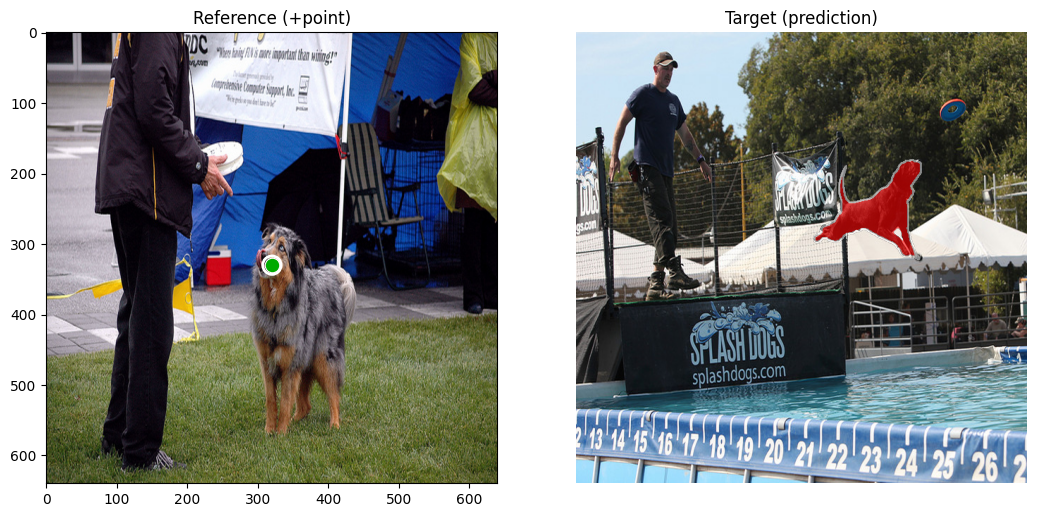

In [8]:
PROMPT_INPUT_MODE = "interactive"   # ✏️ or: "manual"
set_prompt_mode(PROMPT_INPUT_MODE)
ctx_point = DemoCtx(model, reference_img, target_img, device, prompt_type='point')

if PROMPT_INPUT_MODE == 'interactive':
    input_points = []
    demo_points(ctx_point, store=input_points, in_jupyter=IN_JUPYTER)
else:
    # provide points as [[x, y]]
    POINTS = np.array([[320, 330]], dtype=np.float32)  # ✏️ manual points
    pred_mask = predict_with_ctx(ctx_point, POINTS)
    show_ref_tgt(reference_img, target_img, POINTS, pred_mask, 'point', is_manual=True)


## ✏️ 8) Scribble prompt

- **Interactive:** draw a freehand scribble over the object in the reference image.  
- **Manual:** provide only the **start** and **end** points; the helper generates a curved path.

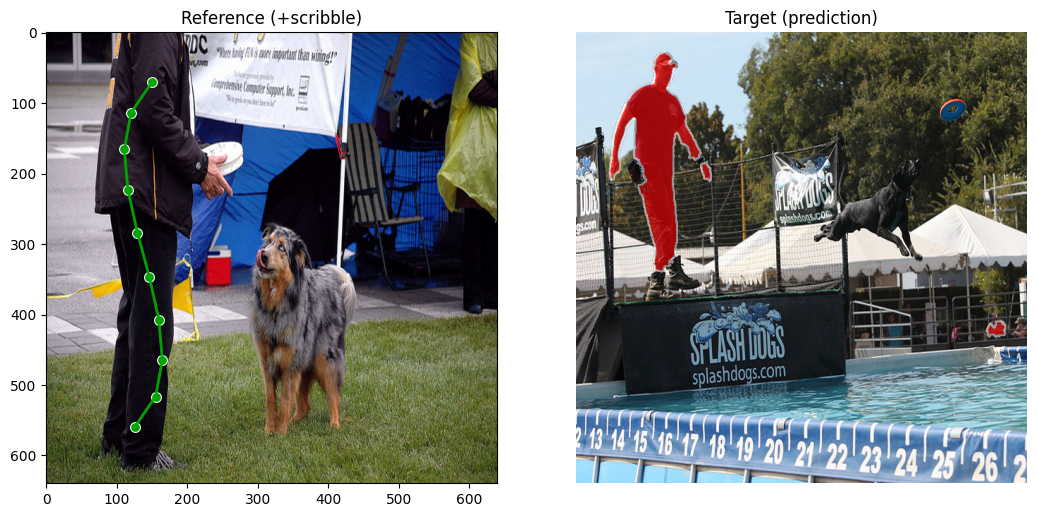

In [9]:
PROMPT_INPUT_MODE = "interactive"   # ✏️ or: "manual"
set_prompt_mode(PROMPT_INPUT_MODE)
ctx_scribble = DemoCtx(model, reference_img, target_img, device, prompt_type='scribble')

if PROMPT_INPUT_MODE == 'interactive':
    input_scribble = []
    demo_scribble(ctx_scribble, store=input_scribble, in_jupyter=IN_JUPYTER)
else:
    START, END = (150, 70), (125, 560)  # ✏️ manual start/end
    SCRIBBLE = generate_scribble(START, END)  # helper creates the path
    pred_mask = predict_with_ctx(ctx_scribble, SCRIBBLE)
    show_ref_tgt(reference_img, target_img, SCRIBBLE, pred_mask, 'scribble', is_manual=True)


## 🎭 9) Mask prompt

- **Interactive:** draw the mask directly around the object on the reference image.  
- **Manual:** provide a binary mask.  

> Heads-up: not every image folder includes masks for every class.  
> If a mask isn’t found, try a different `CLASS_NAME` or pick another example (change `ref_id` in 4.).

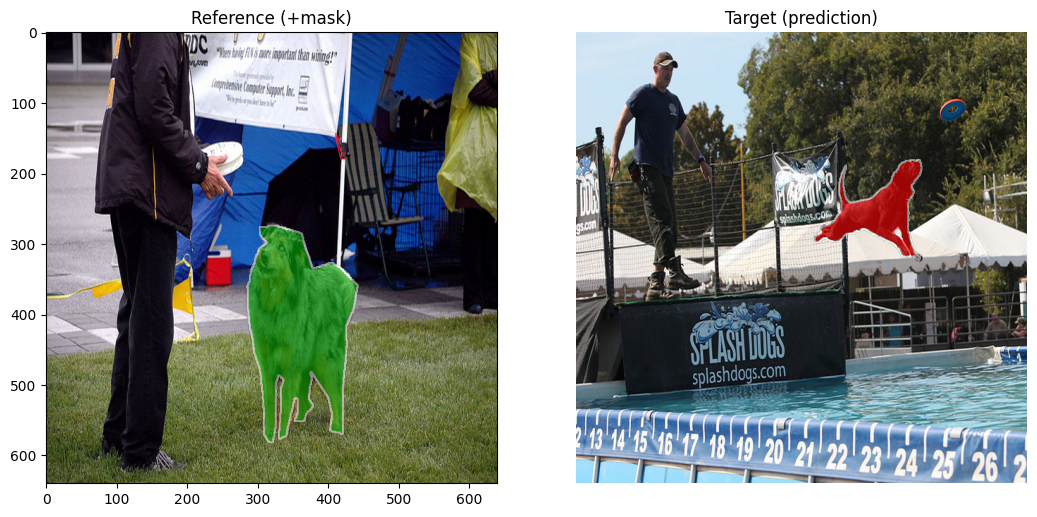

In [10]:
PROMPT_INPUT_MODE = "interactive"   # ✏️ or: "manual"
set_prompt_mode(PROMPT_INPUT_MODE)
ctx_mask = DemoCtx(model, reference_img, target_img, device, prompt_type='mask')

if PROMPT_INPUT_MODE == 'interactive':
    demo_mask(ctx_mask, store=[], in_jupyter=IN_JUPYTER)
else:
    CLASS = "dog"  # ✏️
    mpath = next((p for p in masks[0] if f"_{CLASS.lower()}" in Path(p).stem.lower()), None)
    if mpath is None:
        print(f"Error: no '{CLASS}' mask found for reference image")
    else:
        mask_bin  = (np.array(Image.open(mpath).convert("L").resize((img_size, img_size), Image.NEAREST)) > 0).astype(np.uint8)
        pred_mask = predict_with_ctx(ctx_mask, mask_bin)
        show_ref_tgt(reference_img, target_img, mask_bin, pred_mask, 'mask', is_manual=True)